In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Tofaş.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop(df2[(df2["Fiyat"] > 500000)].index, axis=0, inplace=True)

In [4]:
df2.drop(df2[(df2["Fiyat"] < 60000)].index, axis=0, inplace=True)

In [5]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [6]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Doğan,Seri_Kartal,Seri_Murat,...,Model_Kartal 5 Vites,Model_L,Model_S,Model_SL,Model_SLX,Model_SLX ie,Model_Şahin 5 Vites,Yakıt Tipi_Benzin,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz
0,125000,-1.000000,-0.527778,0.100962,-0.823970,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,105000,-1.363636,-0.527778,0.100962,-0.224719,NaN,NaN,0,1,0,...,1,0,0,0,0,0,0,0,1,1
2,170000,-1.545455,-1.416667,0.100962,0.067416,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,240000,-1.181818,-0.166667,0.100962,-0.617633,NaN,NaN,1,0,0,...,0,0,0,0,0,1,0,0,1,1
4,168000,-1.636364,-0.527778,0.100962,-0.606742,9.0,3.0,1,0,0,...,0,0,0,0,1,0,0,0,1,1


In [7]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [10]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [11]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_1328\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,35463.599025,1.131910e+09,33643.86382,25389.559469


In [12]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:33:31,471] A new study created in memory with name: no-name-3a0e9056-7678-4651-80db-4738fa1ff1d2
[I 2023-05-23 21:33:31,560] Trial 0 finished with value: 31599.182558129123 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.372726077258899, 'max_depth': 9, 'min_child_weight': 184}. Best is trial 0 with value: 31599.182558129123.
[I 2023-05-23 21:33:31,572] Trial 1 finished with value: 136896.34414579856 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.0004468485705255912, 'max_depth': 5, 'min_child_weight': 68}. Best is trial 0 with value: 31599.182558129123.
[I 2023-05-23 21:33:31,585] Trial 5 finished with value: 135867.58236838615 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.0012659546877637506, 'max_depth': 7, 'min_child_weight': 217}. Best is trial 0 with value: 31599.182558129123.
[I 2023-05-23 21:33:31,590] Trial 7 finished with value: 134905.56072832656 and parameters: {

[I 2023-05-23 21:33:32,447] Trial 30 finished with value: 72669.38032002955 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.07104651231564943, 'max_depth': 11, 'min_child_weight': 134}. Best is trial 18 with value: 30770.60757812903.
[I 2023-05-23 21:33:32,480] Trial 31 finished with value: 62953.955978801714 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.08845338058295855, 'max_depth': 11, 'min_child_weight': 129}. Best is trial 18 with value: 30770.60757812903.
[I 2023-05-23 21:33:32,484] Trial 32 finished with value: 62067.366320703295 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.09025649675804644, 'max_depth': 11, 'min_child_weight': 125}. Best is trial 18 with value: 30770.60757812903.
[I 2023-05-23 21:33:32,494] Trial 33 finished with value: 59742.802098844964 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.09445085845772079, 'max_depth': 11, 'min_child_

[I 2023-05-23 21:33:33,670] Trial 61 finished with value: 34912.10633288292 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.19123250979180734, 'max_depth': 3, 'min_child_weight': 40}. Best is trial 44 with value: 30250.81945646871.
[I 2023-05-23 21:33:33,679] Trial 60 finished with value: 33949.0894953884 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.19873338591710815, 'max_depth': 15, 'min_child_weight': 42}. Best is trial 44 with value: 30250.81945646871.
[I 2023-05-23 21:33:33,768] Trial 62 finished with value: 33267.09313641426 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.21774020026683705, 'max_depth': 12, 'min_child_weight': 35}. Best is trial 44 with value: 30250.81945646871.
[I 2023-05-23 21:33:33,788] Trial 63 finished with value: 30967.704119691138 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.3871938495247832, 'max_depth': 12, 'min_child_weight':

[I 2023-05-23 21:33:34,951] Trial 90 finished with value: 32441.520187590224 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.23417811775138314, 'max_depth': 14, 'min_child_weight': 71}. Best is trial 44 with value: 30250.81945646871.
[I 2023-05-23 21:33:34,973] Trial 91 finished with value: 32028.77678593821 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.24808026947967154, 'max_depth': 14, 'min_child_weight': 71}. Best is trial 44 with value: 30250.81945646871.
[I 2023-05-23 21:33:35,028] Trial 92 finished with value: 32961.408213837174 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.3276396721742886, 'max_depth': 14, 'min_child_weight': 139}. Best is trial 44 with value: 30250.81945646871.
[I 2023-05-23 21:33:35,033] Trial 93 finished with value: 30452.54064736976 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.28143887361723047, 'max_depth': 14, 'min_child_weig

[I 2023-05-23 21:33:36,606] Trial 120 finished with value: 30653.0911686089 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.37881830764320723, 'max_depth': 9, 'min_child_weight': 35}. Best is trial 102 with value: 29964.72025960951.
[I 2023-05-23 21:33:36,685] Trial 121 finished with value: 31526.578146608113 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.356043521344409, 'max_depth': 8, 'min_child_weight': 50}. Best is trial 102 with value: 29964.72025960951.
[I 2023-05-23 21:33:36,708] Trial 122 finished with value: 31552.461204858228 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.3108259224231466, 'max_depth': 8, 'min_child_weight': 50}. Best is trial 102 with value: 29964.72025960951.
[I 2023-05-23 21:33:36,725] Trial 124 finished with value: 49178.805888748546 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.1252812418501093, 'max_depth': 9, 'min_child_weigh

[I 2023-05-23 21:33:38,122] Trial 150 finished with value: 32289.038623662604 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.23015101571268895, 'max_depth': 14, 'min_child_weight': 38}. Best is trial 102 with value: 29964.72025960951.
[I 2023-05-23 21:33:38,145] Trial 152 finished with value: 32711.112993469025 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.3390762429746347, 'max_depth': 14, 'min_child_weight': 43}. Best is trial 102 with value: 29964.72025960951.
[I 2023-05-23 21:33:38,180] Trial 151 finished with value: 32622.641425831644 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.22886362829914764, 'max_depth': 14, 'min_child_weight': 62}. Best is trial 102 with value: 29964.72025960951.
[I 2023-05-23 21:33:38,289] Trial 153 finished with value: 37884.52502497781 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.22309892813940596, 'max_depth': 14, 'min_chi

[I 2023-05-23 21:33:39,657] Trial 179 finished with value: 30572.429194649234 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.2785832696896221, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:39,808] Trial 182 finished with value: 30254.2745780682 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.32977786824339245, 'max_depth': 15, 'min_child_weight': 16}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:39,822] Trial 181 finished with value: 31505.938682449338 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.26665910312097607, 'max_depth': 15, 'min_child_weight': 16}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:39,871] Trial 183 finished with value: 30187.98741133366 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.3402274818707062, 'max_depth': 15, 'min_child_w

[I 2023-05-23 21:33:41,261] Trial 209 finished with value: 31188.381365759476 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.42578143225813186, 'max_depth': 15, 'min_child_weight': 33}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:41,404] Trial 212 finished with value: 30027.63122633168 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.3101100662139149, 'max_depth': 15, 'min_child_weight': 15}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:41,449] Trial 211 finished with value: 33553.74314007957 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.31179482350118354, 'max_depth': 15, 'min_child_weight': 194}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:41,575] Trial 215 finished with value: 30467.63139264062 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.3138941303875159, 'max_depth': 15, 'min_child

[I 2023-05-23 21:33:42,994] Trial 238 finished with value: 30106.160768260437 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.37513257205283934, 'max_depth': 15, 'min_child_weight': 11}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:43,025] Trial 241 finished with value: 135406.78193664426 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.0016168710418460208, 'max_depth': 15, 'min_child_weight': 12}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:43,069] Trial 242 finished with value: 29971.027146754506 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.2986787806098927, 'max_depth': 15, 'min_child_weight': 11}. Best is trial 167 with value: 29759.60613289884.
[I 2023-05-23 21:33:43,188] Trial 244 finished with value: 33024.87458912565 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.49546180383051547, 'max_depth': 15, 'min_c

In [14]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 29759.6061
Best params:
	colsample_bytree: 0.3
	subsample: 0.5
	learning_rate: 0.4974236426476558
	max_depth: 15
	min_child_weight: 16


In [15]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.3, 0.4],
                  "max_depth": [10,15],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.3],
               'subsample': [0.5],
               'min_child_weight': [16]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.3, 'learning_rate': 0.3, 'max_depth': 15, 'min_child_weight': 16, 'n_estimators': 500, 'subsample': 0.5}
{'TestDeger': 36233.431130925936, 'MSE': 1202334401.1510684, 'RMSE': 34674.69395901092, 'MAE': 26609.182710981637}


In [16]:
r2 = r2_score(y_test, y_pred)
r2

0.21103114898019826

In [17]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.1927740185433764

In [26]:
marka_model = joblib.dump(grid_final_model, "Tofaş.pkl")

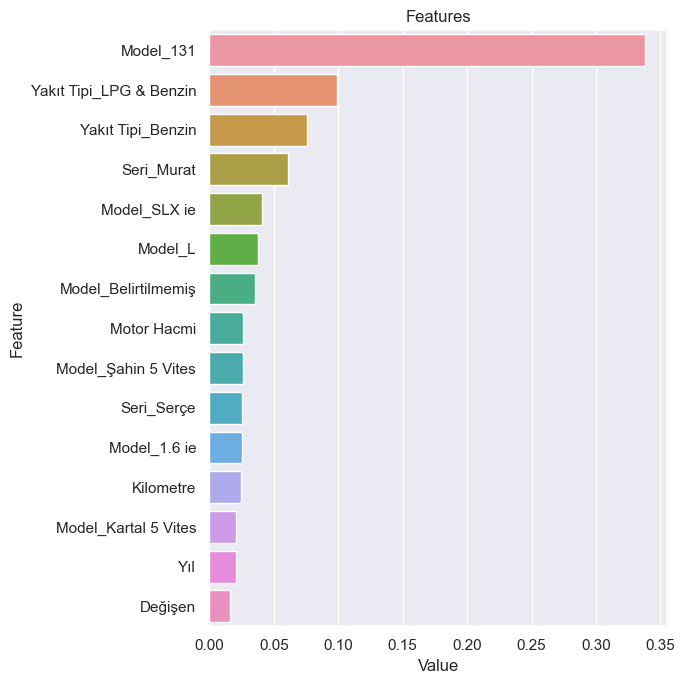

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)

In [19]:
df2.shape

(1770, 29)

In [20]:
y_test2 = list(y_test)

In [21]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [22]:
df3.head(15)

,test,pred,fark
0,70000,48435.898438,-21564.101562
1,150000,104354.757812,-45645.242188
2,167000,146957.328125,-20042.671875
3,130000,131179.234375,1179.234375
4,79500,128611.765625,49111.765625
5,155000,101895.773438,-53104.226562
6,112000,128745.007812,16745.007812
7,187500,157369.968750,-30130.031250
8,113000,75056.429688,-37943.570312
9,135000,208858.812500,73858.812500


In [23]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,531.0,131800.286252,39074.374422,60000.000000,77875.000000,104999.500000,128000.000000,155000.000000,179000.00000,250000.000000,325000.00000
pred,531.0,129916.140625,36088.609375,43284.480469,76691.531250,102712.941406,129157.429688,153453.335938,176137.03125,218328.945313,276706.00000
fark,531.0,-1884.150593,34656.113963,-154581.921875,-57997.269531,-23175.615234,-383.046875,18538.054688,39095.46875,76644.284375,109832.15625


In [81]:
df3["test"].max()

325000

In [24]:
df3["fark"].max()

109832.15625

In [25]:
df3[df3["fark"]==109832.15625]

,test,pred,fark
69,155000,264832.15625,109832.15625


In [82]:
df3[df3["test"]==325000]

,test,pred,fark
523,325000,172351.75,-152648.25


In [37]:
df3[df3["test"] > 400000]

,test,pred,fark


In [31]:
y_train2 = list(y_train)

In [34]:
for i in y_train2:
    if i > 400000:
        print(i)

440000
500000
